In [1]:
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import numpy as np
from collections import defaultdict

from transformers import AutoTokenizer

import contractions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load dataset

In [3]:
dataset = load_dataset("imdb", cache_dir='./data')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
dataset.pop("unsupervised")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

### Find length of texts

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


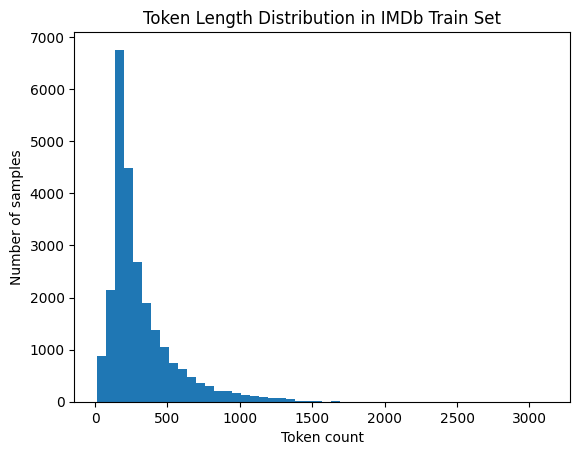

In [6]:
token_lens = []

for sample in dataset["train"]["text"]:
    tokens = tokenizer.encode(sample, truncation=False)
    token_lens.append(len(tokens))

plt.hist(token_lens, bins=50)
plt.xlabel("Token count")
plt.ylabel("Number of samples")
plt.title("Token Length Distribution in IMDb Train Set")
plt.show()


- we can use 256 for max length

### Preprocessing

In [7]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"\[[^]]*\]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_dataset(example):
    example["text"] = clean_text(example["text"])
    return example

In [8]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

In [9]:
clean_datasets = dataset.map(clean_dataset)

tokenized_datasets = clean_datasets.map(tokenize_function, batched=True)

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [11]:
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "label"]
)

### Split data

In [12]:
train = tokenized_datasets['train'].train_test_split(test_size=0.2, shuffle=True)

train

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [13]:
val = train['test']
train = train['train']
test = tokenized_datasets['test']

### Dataloader

In [14]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val, batch_size=32)
test_dataloader = DataLoader(test, batch_size=32)

### GloVe

In [31]:
glove_path = "./data/GLoVe/glove.6B.100d.txt"
embedding_dim = 100
glove_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_index[word] = vector


In [32]:
vocab_size = tokenizer.vocab_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.get_vocab().items():
    vector = glove_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [33]:
glove_embeddings = torch.tensor(embedding_matrix, dtype=torch.float32)

### RNN

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, embed_dim=100, hidden_dim=128, num_layers=1, pad_idx=0, bidirectional=True, dropout=0.5):
        super(RNNClassifier, self).__init__()

        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(embeddings=glove_embeddings, freeze=False, padding_idx=pad_idx)

        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = self.fc = nn.Sequential(
            nn.Linear(hidden_dim * (2 if bidirectional else 1), 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, hidden = self.rnn(embedded)

        if self.bidirectional:
            hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden_cat = hidden[-1]

        out = self.dropout(hidden_cat)
        return self.fc(out)


In [61]:
RNN_classifier = RNNClassifier(bidirectional=False, num_layers=1).to(device)

optimizer_RNN = optim.AdamW(params=RNN_classifier.parameters(), weight_decay=0.01, lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
scheduler_RNN = optim.lr_scheduler.StepLR(optimizer_RNN, step_size=6, gamma=0.5)

#### Training

In [62]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 8
counter = 0
epochs = 30

for epoch in range(epochs):
    RNN_classifier.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_RNN.zero_grad()
        outputs = RNN_classifier(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(RNN_classifier.parameters(), max_norm=1.0)
        optimizer_RNN.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    RNN_classifier.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = RNN_classifier(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(RNN_classifier.state_dict(), "./models/RNNC.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_RNN.step()

[Epoch 1] Train Loss: 434.1469 || Val Loss: 108.7442 | Acc: 0.5198 | F1: 0.6631
Best model saved at epoch 1 with F1: 0.6631


[Epoch 2] Train Loss: 433.4260 || Val Loss: 108.7119 | Acc: 0.5182 | F1: 0.6647
Best model saved at epoch 2 with F1: 0.6647


[Epoch 3] Train Loss: 432.9168 || Val Loss: 108.5543 | Acc: 0.5230 | F1: 0.6128
No improvement for 1 epochs (patience: 8)


[Epoch 4] Train Loss: 430.3191 || Val Loss: 106.5040 | Acc: 0.5586 | F1: 0.3257
No improvement for 2 epochs (patience: 8)


[Epoch 5] Train Loss: 424.6905 || Val Loss: 106.2149 | Acc: 0.5624 | F1: 0.6574
No improvement for 3 epochs (patience: 8)


[Epoch 6] Train Loss: 416.1707 || Val Loss: 101.1763 | Acc: 0.6480 | F1: 0.5996
No improvement for 4 epochs (patience: 8)


[Epoch 7] Train Loss: 394.6468 || Val Loss: 98.9269 | Acc: 0.6834 | F1: 0.7056
Best model saved at epoch 7 with F1: 0.7056


[Epoch 8] Train Loss: 384.7902 || Val Loss: 96.0006 | Acc: 0.6898 | F1: 0.6787
No improvement for 1 epochs (patience: 8)


[Epoch 9] Train Loss: 380.7936 || Val Loss: 94.0186 | Acc: 0.7118 | F1: 0.7182
Best model saved at epoch 9 with F1: 0.7182


[Epoch 10] Train Loss: 372.8581 || Val Loss: 100.6150 | Acc: 0.6514 | F1: 0.5380
No improvement for 1 epochs (patience: 8)


[Epoch 11] Train Loss: 363.3256 || Val Loss: 92.4456 | Acc: 0.7178 | F1: 0.7379
Best model saved at epoch 11 with F1: 0.7379


[Epoch 12] Train Loss: 359.8965 || Val Loss: 93.4671 | Acc: 0.7104 | F1: 0.7469
Best model saved at epoch 12 with F1: 0.7469


[Epoch 13] Train Loss: 350.2609 || Val Loss: 90.6178 | Acc: 0.7278 | F1: 0.7333
No improvement for 1 epochs (patience: 8)


[Epoch 14] Train Loss: 348.1721 || Val Loss: 90.8949 | Acc: 0.7282 | F1: 0.7341
No improvement for 2 epochs (patience: 8)


[Epoch 15] Train Loss: 346.2965 || Val Loss: 91.2635 | Acc: 0.7280 | F1: 0.7518
Best model saved at epoch 15 with F1: 0.7518


[Epoch 16] Train Loss: 342.6432 || Val Loss: 92.2614 | Acc: 0.7210 | F1: 0.6910
No improvement for 1 epochs (patience: 8)


[Epoch 17] Train Loss: 345.1997 || Val Loss: 90.1630 | Acc: 0.7362 | F1: 0.7561
Best model saved at epoch 17 with F1: 0.7561


[Epoch 18] Train Loss: 341.5342 || Val Loss: 89.6570 | Acc: 0.7330 | F1: 0.7458
No improvement for 1 epochs (patience: 8)


[Epoch 19] Train Loss: 336.5033 || Val Loss: 88.9892 | Acc: 0.7430 | F1: 0.7435
No improvement for 2 epochs (patience: 8)


[Epoch 20] Train Loss: 330.9880 || Val Loss: 90.0775 | Acc: 0.7310 | F1: 0.7106
No improvement for 3 epochs (patience: 8)


[Epoch 21] Train Loss: 331.3738 || Val Loss: 88.5680 | Acc: 0.7458 | F1: 0.7555
No improvement for 4 epochs (patience: 8)


[Epoch 22] Train Loss: 331.6487 || Val Loss: 89.0754 | Acc: 0.7396 | F1: 0.7281
No improvement for 5 epochs (patience: 8)


[Epoch 23] Train Loss: 330.3389 || Val Loss: 88.6270 | Acc: 0.7436 | F1: 0.7391
No improvement for 6 epochs (patience: 8)


[Epoch 24] Train Loss: 328.9166 || Val Loss: 88.8201 | Acc: 0.7406 | F1: 0.7349
No improvement for 7 epochs (patience: 8)


[Epoch 25] Train Loss: 325.7122 || Val Loss: 88.7912 | Acc: 0.7406 | F1: 0.7343
No improvement for 8 epochs (patience: 8)
Early stopping at epoch 25. Best F1: 0.7561


### Bidirectional RNN

In [63]:
RNNB_classifier = RNNClassifier(bidirectional=True, num_layers=1).to(device)

optimizer_RNNB = optim.AdamW(params=RNNB_classifier.parameters(), weight_decay=0.01, lr=0.0001)
scheduler_RNNB = optim.lr_scheduler.StepLR(optimizer_RNNB, step_size=6, gamma=0.5)

In [64]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 8
counter = 0
epochs = 30

for epoch in range(epochs):
    RNNB_classifier.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_RNNB.zero_grad()
        outputs = RNNB_classifier(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(RNNB_classifier.parameters(), max_norm=1.0)
        optimizer_RNNB.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    RNNB_classifier.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = RNNB_classifier(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(RNNB_classifier.state_dict(), "./models/RNNB.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_RNNB.step()

[Epoch 1] Train Loss: 433.5778 || Val Loss: 108.6922 | Acc: 0.5144 | F1: 0.2584
Best model saved at epoch 1 with F1: 0.2584


[Epoch 2] Train Loss: 424.4302 || Val Loss: 102.4606 | Acc: 0.6228 | F1: 0.5230
Best model saved at epoch 2 with F1: 0.5230


[Epoch 3] Train Loss: 391.8431 || Val Loss: 93.2917 | Acc: 0.6980 | F1: 0.6814
Best model saved at epoch 3 with F1: 0.6814


[Epoch 4] Train Loss: 365.1130 || Val Loss: 88.8791 | Acc: 0.7240 | F1: 0.7258
Best model saved at epoch 4 with F1: 0.7258


[Epoch 5] Train Loss: 350.3474 || Val Loss: 90.9697 | Acc: 0.7190 | F1: 0.6877
No improvement for 1 epochs (patience: 8)


[Epoch 6] Train Loss: 340.0486 || Val Loss: 97.2945 | Acc: 0.6874 | F1: 0.7490
Best model saved at epoch 6 with F1: 0.7490


[Epoch 7] Train Loss: 316.8281 || Val Loss: 83.1818 | Acc: 0.7582 | F1: 0.7541
Best model saved at epoch 7 with F1: 0.7541


[Epoch 8] Train Loss: 311.2878 || Val Loss: 81.1475 | Acc: 0.7670 | F1: 0.7796
Best model saved at epoch 8 with F1: 0.7796


[Epoch 9] Train Loss: 304.1184 || Val Loss: 82.2032 | Acc: 0.7582 | F1: 0.7435
No improvement for 1 epochs (patience: 8)


[Epoch 10] Train Loss: 294.6797 || Val Loss: 80.3019 | Acc: 0.7726 | F1: 0.7616
No improvement for 2 epochs (patience: 8)


[Epoch 11] Train Loss: 289.1160 || Val Loss: 89.3533 | Acc: 0.7334 | F1: 0.7767
No improvement for 3 epochs (patience: 8)


[Epoch 12] Train Loss: 284.8179 || Val Loss: 82.8082 | Acc: 0.7626 | F1: 0.7916
Best model saved at epoch 12 with F1: 0.7916


[Epoch 13] Train Loss: 269.6122 || Val Loss: 79.4443 | Acc: 0.7788 | F1: 0.7620
No improvement for 1 epochs (patience: 8)


[Epoch 14] Train Loss: 263.7230 || Val Loss: 78.6448 | Acc: 0.7856 | F1: 0.7735
No improvement for 2 epochs (patience: 8)


[Epoch 15] Train Loss: 266.6774 || Val Loss: 76.7405 | Acc: 0.7912 | F1: 0.7823
No improvement for 3 epochs (patience: 8)


[Epoch 16] Train Loss: 260.1298 || Val Loss: 74.5005 | Acc: 0.7960 | F1: 0.7962
Best model saved at epoch 16 with F1: 0.7962


[Epoch 17] Train Loss: 254.2842 || Val Loss: 73.6521 | Acc: 0.7980 | F1: 0.8009
Best model saved at epoch 17 with F1: 0.8009


[Epoch 18] Train Loss: 252.8123 || Val Loss: 75.1023 | Acc: 0.7946 | F1: 0.7857
No improvement for 1 epochs (patience: 8)


[Epoch 19] Train Loss: 246.6700 || Val Loss: 73.8764 | Acc: 0.8014 | F1: 0.7987
No improvement for 2 epochs (patience: 8)


[Epoch 20] Train Loss: 243.7355 || Val Loss: 73.3433 | Acc: 0.8052 | F1: 0.8086
Best model saved at epoch 20 with F1: 0.8086


[Epoch 21] Train Loss: 241.8668 || Val Loss: 74.1553 | Acc: 0.7986 | F1: 0.7934
No improvement for 1 epochs (patience: 8)


[Epoch 22] Train Loss: 239.8456 || Val Loss: 72.8273 | Acc: 0.8074 | F1: 0.8113
Best model saved at epoch 22 with F1: 0.8113


[Epoch 23] Train Loss: 238.0740 || Val Loss: 72.5066 | Acc: 0.8022 | F1: 0.8071
No improvement for 1 epochs (patience: 8)


[Epoch 24] Train Loss: 236.9186 || Val Loss: 73.6435 | Acc: 0.8024 | F1: 0.7983
No improvement for 2 epochs (patience: 8)


[Epoch 25] Train Loss: 231.8213 || Val Loss: 75.7545 | Acc: 0.7982 | F1: 0.7891
No improvement for 3 epochs (patience: 8)


[Epoch 26] Train Loss: 230.9313 || Val Loss: 72.8234 | Acc: 0.8038 | F1: 0.8105
No improvement for 4 epochs (patience: 8)


[Epoch 27] Train Loss: 231.3760 || Val Loss: 72.3564 | Acc: 0.8054 | F1: 0.8074
No improvement for 5 epochs (patience: 8)


[Epoch 28] Train Loss: 227.9256 || Val Loss: 72.3401 | Acc: 0.8084 | F1: 0.8118
Best model saved at epoch 28 with F1: 0.8118


[Epoch 29] Train Loss: 228.8940 || Val Loss: 72.3593 | Acc: 0.8064 | F1: 0.8062
No improvement for 1 epochs (patience: 8)


[Epoch 30] Train Loss: 228.3804 || Val Loss: 71.9554 | Acc: 0.8096 | F1: 0.8122
Best model saved at epoch 30 with F1: 0.8122


### LSTM

In [69]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_layers=1, pad_idx=0, bidirectional=True, hidden_dim=128):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(
            embeddings=glove_embeddings,
            freeze=False,
            padding_idx=pad_idx
        )

        self.lstm = nn.LSTM(
            input_size=100,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0.0
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * (2 if bidirectional else 1), 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        
        pooled = torch.mean(output, dim=1)

        return self.fc(pooled)


#### Train

In [82]:
LSTM_classifier = LSTMClassifier(bidirectional=False, num_layers=2).to(device)

optimizer_LSTM = optim.AdamW(params=LSTM_classifier.parameters(), weight_decay=0.01, lr=0.0005)
scheduler_LSTM = optim.lr_scheduler.StepLR(optimizer_LSTM, step_size=4, gamma=0.5)

In [83]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 5
counter = 0
epochs = 30

for epoch in range(epochs):
    LSTM_classifier.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_LSTM.zero_grad()
        outputs = LSTM_classifier(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(LSTM_classifier.parameters(), max_norm=1.0)
        optimizer_LSTM.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    LSTM_classifier.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = LSTM_classifier(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(LSTM_classifier.state_dict(), "./models/LSTM.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_LSTM.step()

[Epoch 1] Train Loss: 359.4121 || Val Loss: 67.8570 | Acc: 0.8060 | F1: 0.8071
Best model saved at epoch 1 with F1: 0.8071


[Epoch 2] Train Loss: 244.4570 || Val Loss: 57.7111 | Acc: 0.8566 | F1: 0.8622
Best model saved at epoch 2 with F1: 0.8622


[Epoch 3] Train Loss: 183.1084 || Val Loss: 51.1386 | Acc: 0.8698 | F1: 0.8682
Best model saved at epoch 3 with F1: 0.8682


[Epoch 4] Train Loss: 144.5476 || Val Loss: 49.2004 | Acc: 0.8652 | F1: 0.8609
No improvement for 1 epochs (patience: 5)


[Epoch 5] Train Loss: 104.0433 || Val Loss: 52.6560 | Acc: 0.8726 | F1: 0.8730
Best model saved at epoch 5 with F1: 0.8730


[Epoch 6] Train Loss: 87.3315 || Val Loss: 61.8233 | Acc: 0.8758 | F1: 0.8803
Best model saved at epoch 6 with F1: 0.8803


[Epoch 7] Train Loss: 72.2426 || Val Loss: 66.4895 | Acc: 0.8736 | F1: 0.8787
No improvement for 1 epochs (patience: 5)


[Epoch 8] Train Loss: 58.7923 || Val Loss: 75.4660 | Acc: 0.8698 | F1: 0.8684
No improvement for 2 epochs (patience: 5)


[Epoch 9] Train Loss: 41.3751 || Val Loss: 88.4391 | Acc: 0.8658 | F1: 0.8734
No improvement for 3 epochs (patience: 5)


[Epoch 10] Train Loss: 35.1479 || Val Loss: 108.5082 | Acc: 0.8574 | F1: 0.8505
No improvement for 4 epochs (patience: 5)


[Epoch 11] Train Loss: 30.9337 || Val Loss: 108.3245 | Acc: 0.8672 | F1: 0.8697
No improvement for 5 epochs (patience: 5)
Early stopping at epoch 11. Best F1: 0.8803


### Bidirectional LSTM

In [92]:
LSTMB_classifier = LSTMClassifier(bidirectional=True, num_layers=2).to(device)

optimizer_LSTMB = optim.AdamW(params=LSTMB_classifier.parameters(), weight_decay=0.01, lr=0.0005)
scheduler_LSTMB = optim.lr_scheduler.StepLR(optimizer_LSTMB, step_size=5, gamma=0.5)

In [93]:
accuracy_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

best_f1 = 0
patience = 5
counter = 0
epochs = 30

for epoch in range(epochs):
    LSTMB_classifier.train()
    total_loss = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
    for batch in train_loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)

        optimizer_LSTMB.zero_grad()
        outputs = LSTMB_classifier(input_ids)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()

        nn.utils.clip_grad_norm_(LSTMB_classifier.parameters(), max_norm=1.0)
        optimizer_LSTMB.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    LSTMB_classifier.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad() :
        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = LSTMB_classifier(input_ids)
            loss = criterion(outputs.view(-1), labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().view(-1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loop.set_postfix(loss=loss.item())

    
    current_acc = accuracy_metric.compute().item()
    current_f1 = f1_metric.compute().item()


    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {current_acc:.4f} | F1: {current_f1:.4f}")
    
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        counter = 0
        torch.save(LSTMB_classifier.state_dict(), "./models/LSTMB.pth")
        print(f"Best model saved at epoch {epoch+1} with F1: {best_f1:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs (patience: {patience})")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
        break
    
    scheduler_LSTMB.step()

[Epoch 1] Train Loss: 339.3043 || Val Loss: 73.3860 | Acc: 0.7852 | F1: 0.8183
Best model saved at epoch 1 with F1: 0.8183


[Epoch 2] Train Loss: 211.7106 || Val Loss: 51.3650 | Acc: 0.8630 | F1: 0.8609
Best model saved at epoch 2 with F1: 0.8609


[Epoch 3] Train Loss: 166.5329 || Val Loss: 58.4709 | Acc: 0.8402 | F1: 0.8231
No improvement for 1 epochs (patience: 5)


[Epoch 4] Train Loss: 133.0398 || Val Loss: 51.9453 | Acc: 0.8736 | F1: 0.8714
Best model saved at epoch 4 with F1: 0.8714


[Epoch 5] Train Loss: 98.3676 || Val Loss: 53.3573 | Acc: 0.8726 | F1: 0.8724
Best model saved at epoch 5 with F1: 0.8724


[Epoch 6] Train Loss: 64.3946 || Val Loss: 75.2889 | Acc: 0.8718 | F1: 0.8689
No improvement for 1 epochs (patience: 5)


[Epoch 7] Train Loss: 51.5596 || Val Loss: 82.3766 | Acc: 0.8644 | F1: 0.8644
No improvement for 2 epochs (patience: 5)


[Epoch 8] Train Loss: 39.7101 || Val Loss: 95.2316 | Acc: 0.8660 | F1: 0.8648
No improvement for 3 epochs (patience: 5)


[Epoch 9] Train Loss: 28.7080 || Val Loss: 151.7306 | Acc: 0.8326 | F1: 0.8129
No improvement for 4 epochs (patience: 5)


[Epoch 10] Train Loss: 23.3967 || Val Loss: 134.6630 | Acc: 0.8644 | F1: 0.8692
No improvement for 5 epochs (patience: 5)
Early stopping at epoch 10. Best F1: 0.8724


#### Load Models

In [96]:
RNN_classifier.load_state_dict(torch.load("./models/RNNC.pth"))
RNNB_classifier.load_state_dict(torch.load("./models/RNNB.pth"))
LSTM_classifier.load_state_dict(torch.load("./models/LSTM.pth"))
LSTMB_classifier.load_state_dict(torch.load("./models/LSTMB.pth"))

<All keys matched successfully>

### Test

In [100]:
def create_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75}
    )


    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [101]:
def Test_verification(model):
    accuracy_metric_test = BinaryAccuracy().to(device)
    f1_metric_test = BinaryF1Score().to(device)
    CF = BinaryConfusionMatrix().to(device)

    model.eval()
    with torch.no_grad():
        val_loop = tqdm(test_dataloader, desc="Test [Evaluation]", leave=False)
        for batch in val_loop:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].float().to(device)

            outputs = model(input_ids)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().squeeze(1)

            accuracy_metric_test.update(preds, labels)
            f1_metric_test.update(preds, labels)
            CF.update(preds, labels)

    print(f"Test F1: {f1_metric_test.compute().item():.4f}")
    print(f"Test Accuracy: {accuracy_metric_test.compute().item():.4f}")

    create_heatmap(CF)

Test F1: 0.7510
Test Accuracy: 0.7340


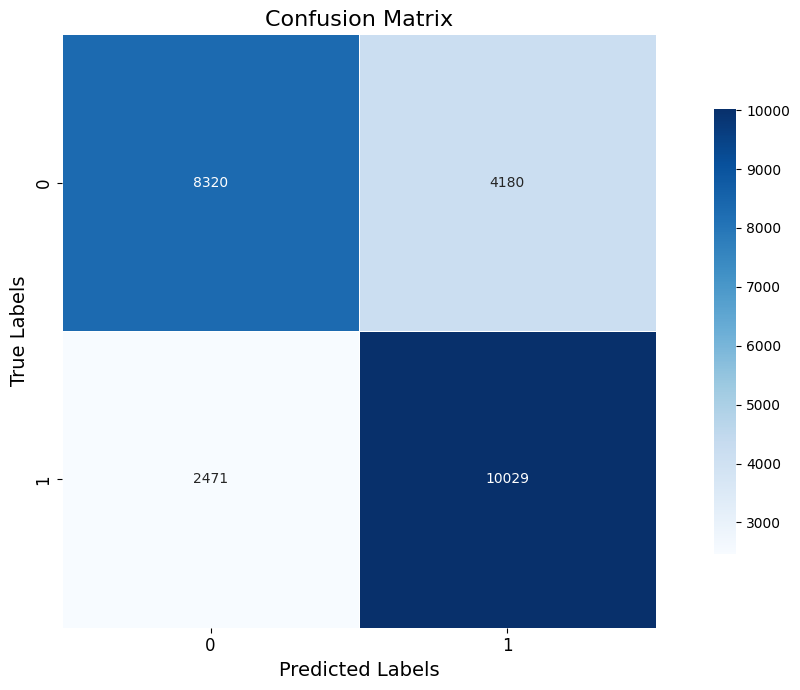

In [102]:
Test_verification(RNN_classifier)

Test F1: 0.7957
Test Accuracy: 0.7964


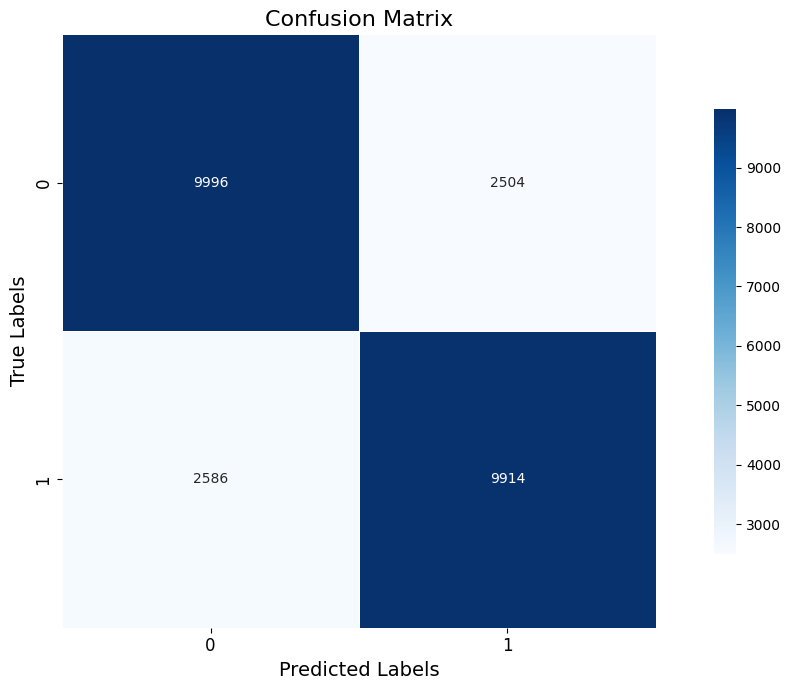

In [103]:
Test_verification(RNNB_classifier)

Test F1: 0.8532
Test Accuracy: 0.8509


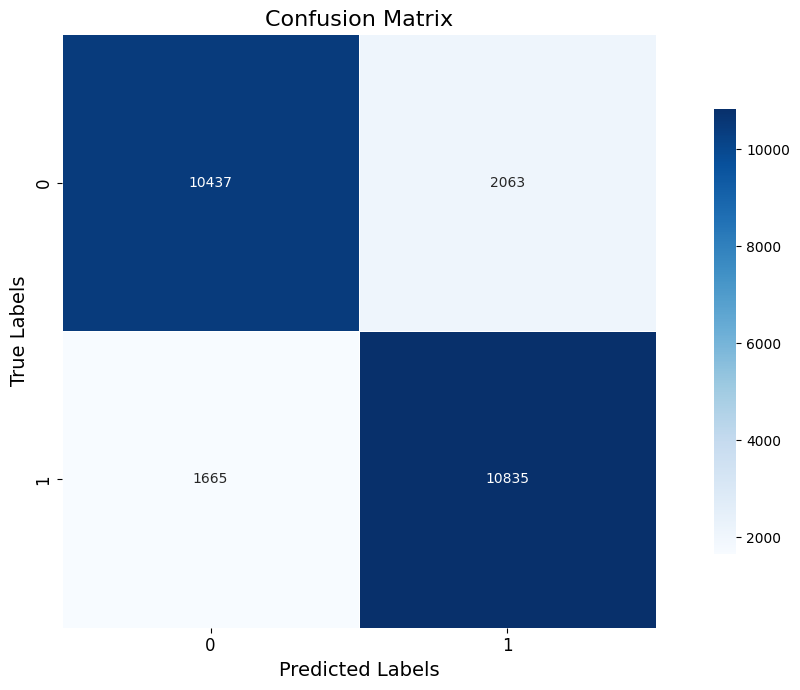

In [104]:
Test_verification(LSTM_classifier)

Test F1: 0.8510
Test Accuracy: 0.8558


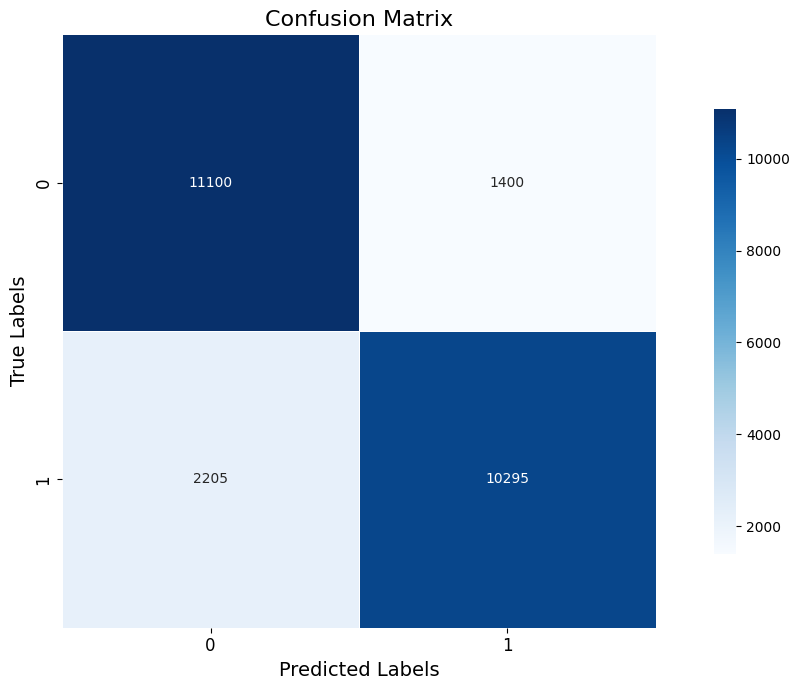

In [105]:
Test_verification(LSTMB_classifier)

# 📊 Model Training Results

## 🔹 Model 1: **RNN**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note                 |
| ----- | ---------- | -------- | -------- | -------- | -------------------- |
| 1     | 434.1469   | 108.7442 | 0.5198   | 0.6631   | ✅ Best model         |
| 2     | 433.4260   | 108.7119 | 0.5182   | 0.6647   | ✅ Best model         |
| 3     | 432.9168   | 108.5543 | 0.5230   | 0.6128   | No improvement       |
| 7     | 394.6468   | 98.9269  | 0.6834   | 0.7056   | ✅ Best model         |
| 9     | 380.7936   | 94.0186  | 0.7118   | 0.7182   | ✅ Best model         |
| 11    | 363.3256   | 92.4456  | 0.7178   | 0.7379   | ✅ Best model         |
| 12    | 359.8965   | 93.4671  | 0.7104   | 0.7469   | ✅ Best model         |
| 15    | 346.2965   | 91.2635  | 0.7280   | 0.7518   | ✅ Best model         |
| 17    | 345.1997   | 90.1630  | 0.7362   | 0.7561   | ✅ Best model (Final) |

**🛑 Early Stopping at Epoch 25**
✅ **Best F1:** 0.7561
✅ **Test F1:** 0.7510
✅ **Test Accuracy:** 0.7340

---

## 🔹 Model 2: **RNN (Bidirectional)**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note                 |
| ----- | ---------- | -------- | -------- | -------- | -------------------- |
| 1     | 433.5778   | 108.6922 | 0.5144   | 0.2584   | ✅ Best model         |
| 2     | 424.4302   | 102.4606 | 0.6228   | 0.5230   | ✅ Best model         |
| 3     | 391.8431   | 93.2917  | 0.6980   | 0.6814   | ✅ Best model         |
| 4     | 365.1130   | 88.8791  | 0.7240   | 0.7258   | ✅ Best model         |
| 6     | 340.0486   | 97.2945  | 0.6874   | 0.7490   | ✅ Best model         |
| 7     | 316.8281   | 83.1818  | 0.7582   | 0.7541   | ✅ Best model         |
| 8     | 311.2878   | 81.1475  | 0.7670   | 0.7796   | ✅ Best model         |
| 12    | 284.8179   | 82.8082  | 0.7626   | 0.7916   | ✅ Best model         |
| 16    | 260.1298   | 74.5005  | 0.7960   | 0.7962   | ✅ Best model         |
| 17    | 254.2842   | 73.6521  | 0.7980   | 0.8009   | ✅ Best model         |
| 20    | 243.7355   | 73.3433  | 0.8052   | 0.8086   | ✅ Best model         |
| 22    | 239.8456   | 72.8273  | 0.8074   | 0.8113   | ✅ Best model         |
| 28    | 227.9256   | 72.3401  | 0.8084   | 0.8118   | ✅ Best model         |
| 30    | 228.3804   | 71.9554  | 0.8096   | 0.8122   | ✅ Best model (Final) |

✅ **Best F1:** 0.8122
✅ **Test F1:** 0.7957
✅ **Test Accuracy:** 0.7964

---

## 🔹 Model 3: **LSTM**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note                 |
| ----- | ---------- | -------- | -------- | -------- | -------------------- |
| 1     | 359.4121   | 67.8570  | 0.8060   | 0.8071   | ✅ Best model         |
| 2     | 244.4570   | 57.7111  | 0.8566   | 0.8622   | ✅ Best model         |
| 3     | 183.1084   | 51.1386  | 0.8698   | 0.8682   | ✅ Best model         |
| 5     | 104.0433   | 52.6560  | 0.8726   | 0.8730   | ✅ Best model         |
| 6     | 87.3315    | 61.8233  | 0.8758   | 0.8803   | ✅ Best model (Final) |

**🛑 Early Stopping at Epoch 11**
✅ **Best F1:** 0.8803
✅ **Test F1:** 0.8532
✅ **Test Accuracy:** 0.8509

---

## 🔹 Model 4: **LSTM (Bidirectional)**

| Epoch | Train Loss | Val Loss | Accuracy | F1 Score | Note         |
| ----- | ---------- | -------- | -------- | -------- | ------------ |
| 1     | 339.3043   | 73.3860  | 0.7852   | 0.8183   | ✅ Best model |
| 2     | 211.7106   | 51.3650  | 0.8630   | 0.8609   | ✅ Best model |
| 4     | 133.0398   | 51.9453  | 0.8736   | 0.8714   | ✅ Best model |
| 5     | 98.3676    | 53.3573  | 0.8726   | 0.8724   | ✅ Best model |

*(Training stopped early after F1 declined for multiple epochs.)*

---

### 📊 **Model Comparison Summary**

| Model                    | Best F1 | Test F1 | Test Accuracy | Convergence Speed    | Final Stability      |
| ------------------------ | ------- | ------- | ------------- | -------------------- | -------------------- |
| **RNN**                  | 0.7561  | 0.7510  | 0.7340        | Slow (25 epochs)     | Early stopping at 25 |
| **RNN (Bidirectional)**  | 0.8122  | 0.7957  | 0.7964        | Moderate (30 epochs) | Gradual improvement  |
| **LSTM**                 | 0.8803  | 0.8532  | 0.8509        | Fast (6 epochs)      | Early stopping at 11 |
| **LSTM (Bidirectional)** | 0.8724  | 0.8510       | 0.8558             | Moderate (5 epochs)  | Early stopping at 10 |

---

### 🔍 **Observations**

1. **Best Overall Performance:**
   ✅ **LSTM (single direction)** achieved the **highest F1 (0.8803)** and **fastest convergence** (best epoch at 6).

2. **Best Bidirectional Model:**
   ✅ **Bidirectional LSTM** is slightly lower than LSTM in F1 but still better than RNN-based models.

3. **RNN vs LSTM:**
   🔻 Both **RNN models perform worse** in F1, accuracy, and convergence speed.
   🔺 LSTM models **learn faster and generalize better**.

4. **Bidirectional Benefit:**

   * For RNN, **bidirectional improves performance significantly** (from 0.7561 → 0.8122 F1).
   * For LSTM, **bidirectional does not outperform single LSTM**.

---

### 📈 **Ranking by Test F1 Score**

1️⃣ **LSTM (0.8532)**
2️⃣ **Bidirectional LSTM (\~0.85, best F1 = 0.8724)**
3️⃣ **Bidirectional RNN (0.7957)**
4️⃣ **RNN (0.7510)**

